<a href="https://colab.research.google.com/github/hoonzi-s/APC/blob/main/%231ALK_213BTMRVP_R5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split as tts
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score
from xgboost import XGBRegressor

## Get Data

In [7]:
data_origin = pd.read_csv('/content/drive/MyDrive/#1 ALK RVP CSV.csv', index_col = 0)
data_origin.info()
data_origin.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 2753 entries, 2014-09-16 to 2022-06-30
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   RVP_LAB         2753 non-null   float64
 1   S.B5.213TI2804  2753 non-null   float64
 2   S.B5.213PI2806  2753 non-null   float64
 3   S.B5.213FC2602  2753 non-null   float64
dtypes: float64(4)
memory usage: 107.5+ KB


,RVP_LAB,S.B5.213TI2804,S.B5.213PI2806,S.B5.213FC2602
count,2753.00000,2753.000000,2753.000000,2753.000000
mean,39.41551,133.889974,335.177430,85.890540
std,3.53523,3.471188,29.578899,10.688965
min,28.50000,98.364672,293.412469,33.324527
25%,37.50000,131.923775,318.182670,81.066149
50%,39.00000,133.375011,325.641719,88.489940
75%,40.80000,136.082275,339.128497,92.699854
max,98.60000,145.946073,516.111992,112.931605


In [8]:
data_origin.columns = ['RVP', 'T', 'P', 'F']
data = data_origin[(data_origin.iloc[:, 0] < 70) & (data_origin.iloc[:, 1] > 120)]
data.iloc[:, 1] += 273.15     # to Absolute
data.iloc[:, 2] += 101.325    # to Absolute
lab = data.iloc[:, 0]

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


In [9]:
information = pd.DataFrame(columns=['Variables', 'Solution', 'Alpha', 'Scaler', 'train_R2', 'test_R2', 'R2' 'MAE', 'MSE'])
information

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2MAE,MSE


# Existing Inferential (PCT by Song)

In [10]:
T = data['T']
P = data['P']/101.325
lnP = np.log(P)

exist = np.exp(51.596*(311-T*(16052-1902*lnP)/(16052-P*lnP))/(1902-T*(16052-1902*lnP)/(16052-P*lnP)))*101.325-4.50907
exist

2014-09-16    35.539507
2014-09-17    33.800584
2014-09-18    34.720362
2014-09-19    35.013853
2014-09-20    37.005404
                ...    
2022-06-26    48.077813
2022-06-27    51.949963
2022-06-28    57.963941
2022-06-29    52.213072
2022-06-30    53.660578
Length: 2750, dtype: float64

In [11]:
mae = MAE(lab, exist)
mse = MSE(lab, exist)
r2 = r2_score(lab, exist)   # 낮을 수록 좋은 것
r2_inv = 1 - r2

new = pd.DataFrame({'Solution': 'exist',
                    'R2' : r2,
                    '1-R2' : r2_inv,
                    'MAE': mae, 
                    'MSE': mse}, 
                   index = [0])
information = pd.concat([information, new])
new

,Solution,R2,1-R2,MAE,MSE
0,exist,0.303459,0.696541,2.128567,7.802287


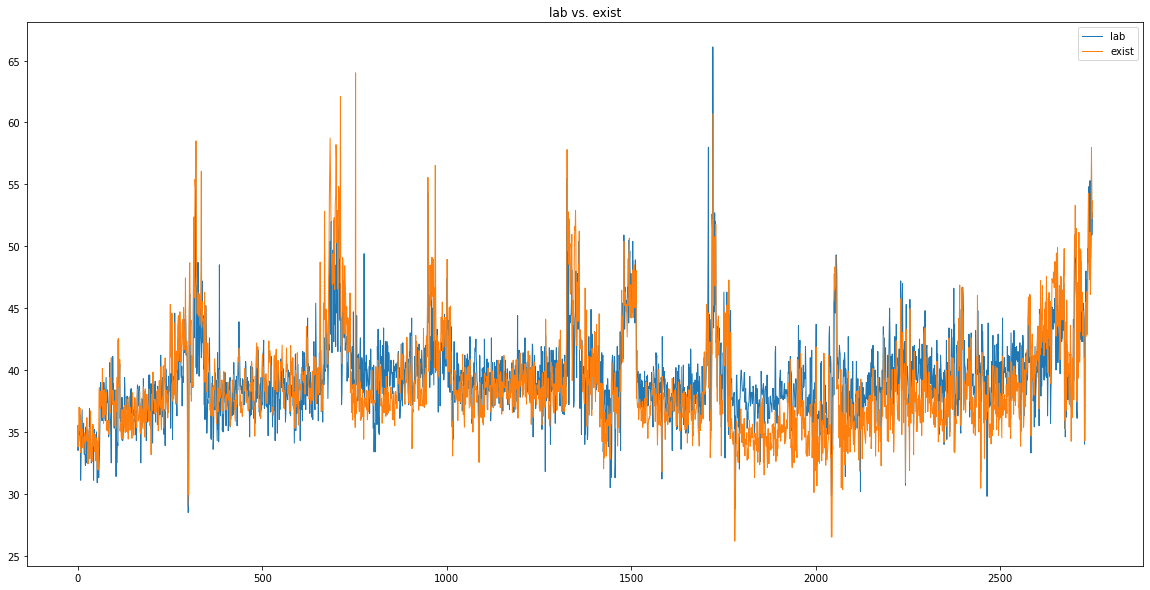

In [12]:
plt.figure(figsize = (20, 10))
plt.plot(np.arange(2750), lab, label = 'lab', lw = 1)
plt.plot(np.arange(2750), exist, label = 'exist', lw = 1)
plt.legend()
plt.title('lab vs. exist')
plt.show()

In [12]:
xgb = XGBRegressor()
xgb.fit()